# Paper example : 10k PBMCs sequenced by 10X scATAC-seq

To run this notebook you will need to download the data from [Zenodo](https://doi.org/10.5281/zenodo.10561582):
```sh
wget https://zenodo.org/records/10708208/files/scATAC.zip
wget https://zenodo.org/records/10708208/files/GO_files.zip
wget https://zenodo.org/records/10708208/files/genome_annot.zip
unzip scATAC.zip
unzip GO_files.zip
unzip genome_annot.zip
```

It will also require scran (see R dependencies), as well as HarmonyPy to perform data integration:
```sh
pip install harmonypy
pip install tables
```

First, load dependencies and set data paths. 

In [57]:
import sys
sys.path.append("./")
import pandas as pd
import numpy as np
import os
import muffin
import scanpy as sc
import matplotlib.pyplot as plt

path_gencode, path_chromsizes, path_GOfile = "genome_annot/gencode.v45lift37.basic.annotation.gtf", "genome_annot/hg19.chrom.sizes", "GO_files/hsapiens.GO:BP.name.gmt"
path_scAtacHD5, path_barcode_metadata, path_pre_analyzed_10k_pbmcs = "scATAC/atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5", "scATAC/atac_v1_pbmc_10k_singlecell.csv", "scATAC/dataset.h5ad"



You can set plot settings for muffin :

In [58]:
try:
    os.mkdir("scATAC_pbmc/")
except FileExistsError:
    pass
muffin.params["autosave_plots"] = "scATAC_pbmc/"
muffin.params["figure_dpi"] = 96
muffin.params["autosave_format"] = ".pdf"
sc.set_figure_params(dpi=96, dpi_save=500)
sc.set_figure_params(dpi=96, dpi_save=500)
sc.settings.autosave = True
sc.settings.figdir = "scATAC_pbmc/"
# Makes pdf font editable with pdf editors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/_settings.py:450: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



Scanpy 10x_h5 loader did not work for this dataset, we use the python code provided by 10X

In [59]:
import scipy.sparse as sp_sparse
import collections
import tables
import pyranges as pr
CountMatrix = collections.namedtuple('CountMatrix', ['feature_ref', 'barcodes', 'matrix'])
def get_matrix_from_h5(filename):
    with tables.open_file(filename, 'r') as f:
        mat_group = f.get_node(f.root, 'matrix')
        barcodes = f.get_node(mat_group, 'barcodes').read()
        data = getattr(mat_group, 'data').read()
        indices = getattr(mat_group, 'indices').read()
        indptr = getattr(mat_group, 'indptr').read()
        shape = getattr(mat_group, 'shape').read()
        matrix = sp_sparse.csc_array((data, indices, indptr), shape=shape)
        feature_ref = {}
        feature_group = f.get_node(mat_group, 'features')
        feature_ids = getattr(feature_group, 'id').read()
        feature_names = getattr(feature_group, 'name').read()
        feature_types = getattr(feature_group, 'feature_type').read()
        feature_ref['id'] = feature_ids
        feature_ref['name'] = feature_names
        feature_ref['feature_type'] = feature_types
        tag_keys = getattr(feature_group, '_all_tag_keys').read()
        for key in tag_keys:
            key = key.decode("utf-8")
            feature_ref[key] = getattr(feature_group, key).read()
        return CountMatrix(feature_ref, barcodes, matrix)
mat = get_matrix_from_h5(path_scAtacHD5)

Setup the gene set enrichment tool. It also allows to link genomic regions to their nearest gene on top of performing GSEA.

In [60]:
gsea_obj = muffin.great.pyGREAT(path_gencode, path_chromsizes, path_GOfile)
positions = pd.DataFrame([x.split(':')[0:1] + x.split(':')[1].split('-') for x in mat.feature_ref["name"].astype(str)],
                         columns=['Chromosome', 'Start', 'End'])
names = gsea_obj.label_by_nearest_gene(pr.PyRanges(positions))

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/great.py:152: FutureWarning:

Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/shared/projects/pol2_chipseq/pkg/miniconda3/e

Load the dataset in the annData format (sparse data format are not supported).

In [61]:
dataset = muffin.load.dataset_from_arrays(mat.matrix.astype("int32").toarray().T, 
                                               mat.barcodes.astype(str), 
                                               names)
# Add peak metadata
for k in mat.feature_ref.keys():
    if k == "id":
        continue
    dataset.var[k] = mat.feature_ref[k].astype(str)
dataset.var[positions.columns] = positions.values
# Add cell/barcode metadata
mappingTab = pd.read_csv(path_barcode_metadata, index_col="barcode").loc[mat.barcodes.astype(str)]
dataset.obs[mappingTab.columns] = mappingTab.values

Compute and plot QC metrics.

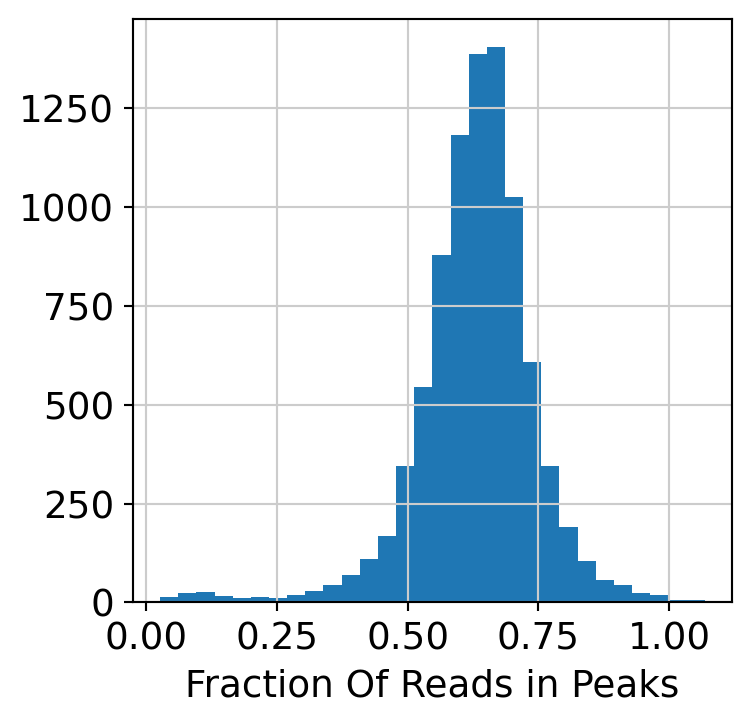

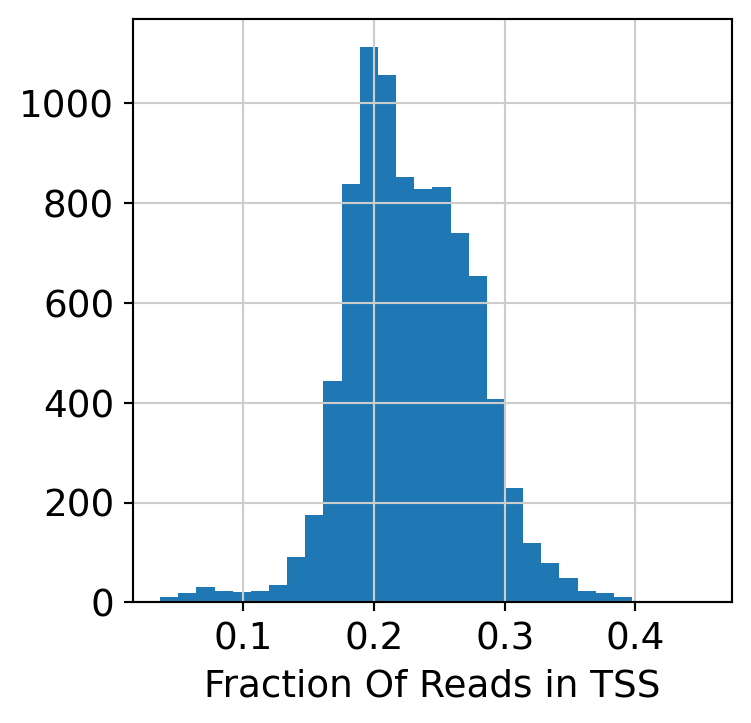

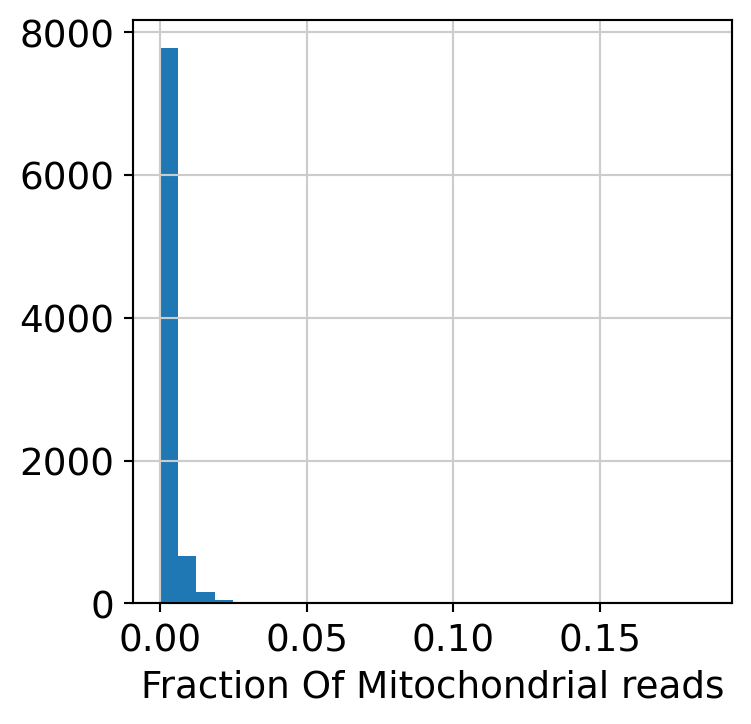

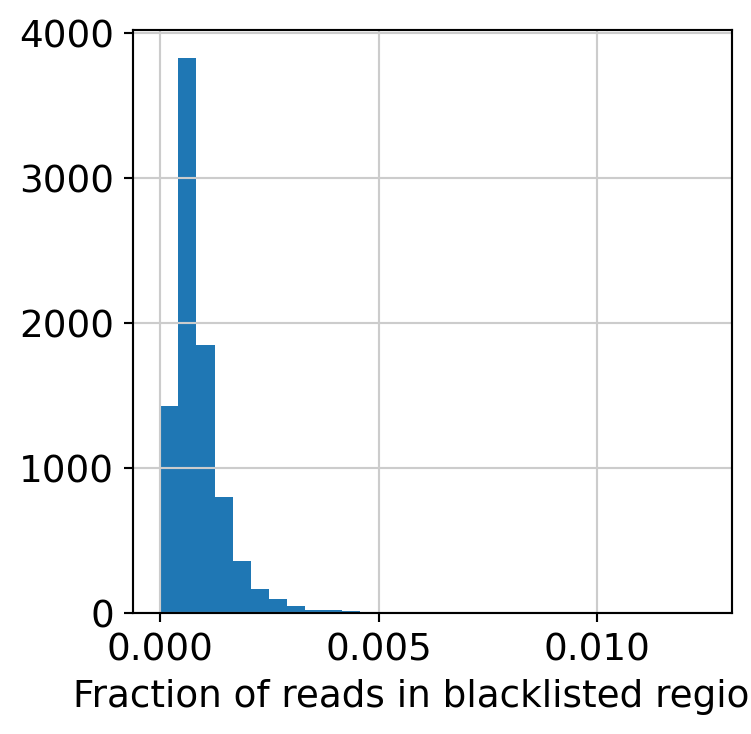

In [62]:
dataset.obs["FRiP"] = np.sum(dataset.X, axis=1) / dataset.obs["total"].values
dataset.obs["TSS_frac"] = dataset.obs["TSS_fragments"] / dataset.obs["total"].values
dataset.obs["MT_frac"] = dataset.obs["mitochondrial"] / dataset.obs["total"].values
dataset.obs["blacklist_frac"] = dataset.obs["blacklist_region_fragments"] / dataset.obs["total"].values
plt.hist(dataset.obs["FRiP"], 30)
plt.xlabel("Fraction Of Reads in Peaks")
plt.show()
plt.close()
plt.hist(dataset.obs["TSS_frac"], 30)
plt.xlabel("Fraction Of Reads in TSS")
plt.show()
plt.close()
plt.hist(dataset.obs["MT_frac"], 30)
plt.xlabel("Fraction Of Mitochondrial reads")
plt.show()
plt.close()
plt.hist(dataset.obs["blacklist_frac"], 30)
plt.xlabel("Fraction of reads in blacklisted regions")
plt.show()
plt.close()

Filter low quality cells.

In [63]:
dataset = dataset[dataset.obs.FRiP > 0.2, :]
dataset = dataset[dataset.obs.TSS_frac > 0.1, :]
dataset = dataset[dataset.obs.MT_frac < 0.025, :]
dataset = dataset[dataset.obs.blacklist_frac < 0.005, :]
dataset = dataset[np.sum(dataset.X, axis=1) < 30000, :]
dataset = dataset[np.sum(dataset.X, axis=1) > 3000, :]

Here, we set up the design matrix of the linear model. Here, we regress out the Fraction of Reads In Peaks (FRiP), so we supply the FRiP as well as an intercept of ones in a (n_cells, 2) shaped matrix. Note that it can have a tendency to "over-regress" and remove biological signal as it is a simple linear correction.

In [64]:
design = np.array([dataset.obs.FRiP.values, np.ones((dataset.X.shape[0]))]).T.astype("float")
print(design)
print(design.shape)
muffin.load.set_design_matrix(dataset, design)

[[0.57422164 1.        ]
 [0.73713657 1.        ]
 [0.60582268 1.        ]
 ...
 [0.74919664 1.        ]
 [0.60279751 1.        ]
 [0.69280123 1.        ]]
(7304, 2)


/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/load.py:256: ImplicitModificationWarning:

Setting element `.obsm['design']` of view, initializing view as actual.



Now, we are going to normalize library sizes using the scran approach, which is well suited to a large number of observations and small counts with many zeroes. We are also going to remove features with very low signal (note that it is mandatory to remove all zero counts).

In [65]:
detectable = muffin.tools.trim_low_counts(dataset)
dataset = dataset[:, detectable]
muffin.tools.compute_size_factors(dataset, "scran")

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/tools.py:435: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



AnnData object with n_obs × n_vars = 7304 × 88512
    obs: 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'FRiP', 'TSS_frac', 'MT_frac', 'blacklist_frac', 'size_factors'
    var: 'name', 'feature_type', 'genome', 'derivation', 'Chromosome', 'Start', 'End'
    obsm: 'design'

The next step is to fit the mean-variance relationship and compute residuals to the fitted Negative Binomial model.

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 248 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Done 2000 out of 2000 | elapsed:  2.3min finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:  1.2min
[Parallel(n_jobs=16)]: Done 78041 tasks      | elapsed:  5.7min
[Parallel(n_jobs=16)]: Done 88512 out of 88512 | elapsed:  6.2min finished
/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/tools.py:537: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



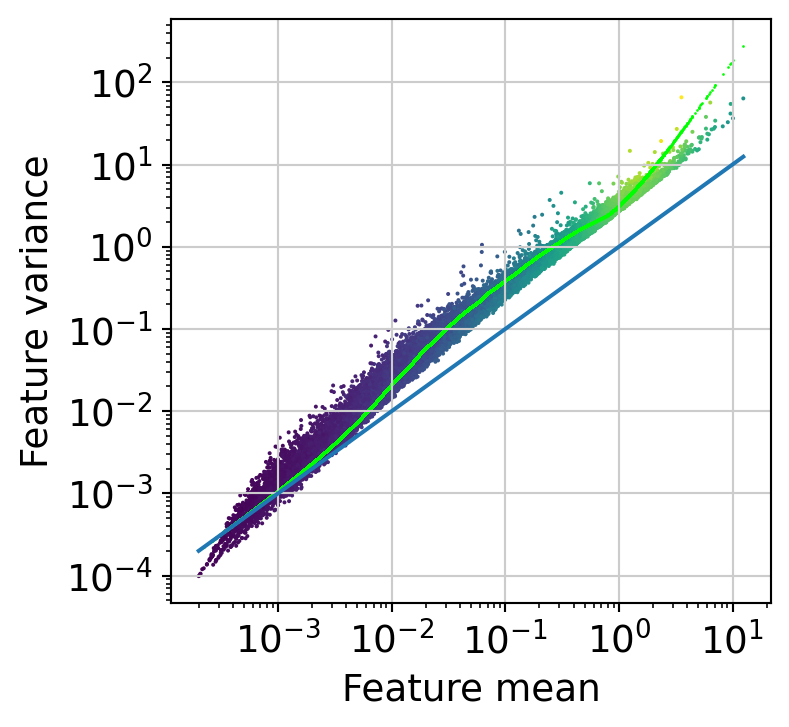

AnnData object with n_obs × n_vars = 7304 × 88512
    obs: 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'FRiP', 'TSS_frac', 'MT_frac', 'blacklist_frac', 'size_factors'
    var: 'name', 'feature_type', 'genome', 'derivation', 'Chromosome', 'Start', 'End', 'means', 'variances', 'reg_alpha'
    obsm: 'design'
    layers: 'residuals'

In [66]:
muffin.tools.compute_residuals(dataset, maxThreads=16)

Next, we perform dimensionnality reduction with PCA (automatically finding the optimal dimensionnality) and UMAP.

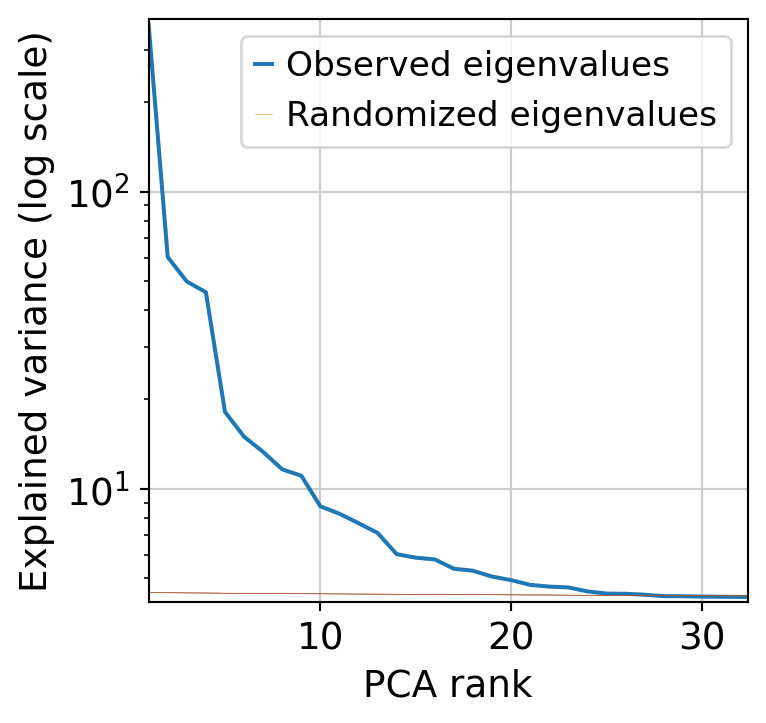

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



AnnData object with n_obs × n_vars = 7304 × 88512
    obs: 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'FRiP', 'TSS_frac', 'MT_frac', 'blacklist_frac', 'size_factors'
    var: 'name', 'feature_type', 'genome', 'derivation', 'Chromosome', 'Start', 'End', 'means', 'variances', 'reg_alpha'
    uns: 'pca'
    obsm: 'design', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'residuals'

In [67]:
muffin.tools.compute_pa_pca(dataset, max_rank=50, plot=True)
muffin.tools.compute_umap(dataset)

Now, cluster the cells. You could use the function from scanpy as well.

In [68]:
muffin.tools.cluster_rows_leiden(dataset)

AnnData object with n_obs × n_vars = 7304 × 88512
    obs: 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'FRiP', 'TSS_frac', 'MT_frac', 'blacklist_frac', 'size_factors', 'leiden'
    var: 'name', 'feature_type', 'genome', 'derivation', 'Chromosome', 'Start', 'End', 'means', 'variances', 'reg_alpha'
    uns: 'pca'
    obsm: 'design', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'residuals'

Display the results. Note that we can use scanpy functions here!

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



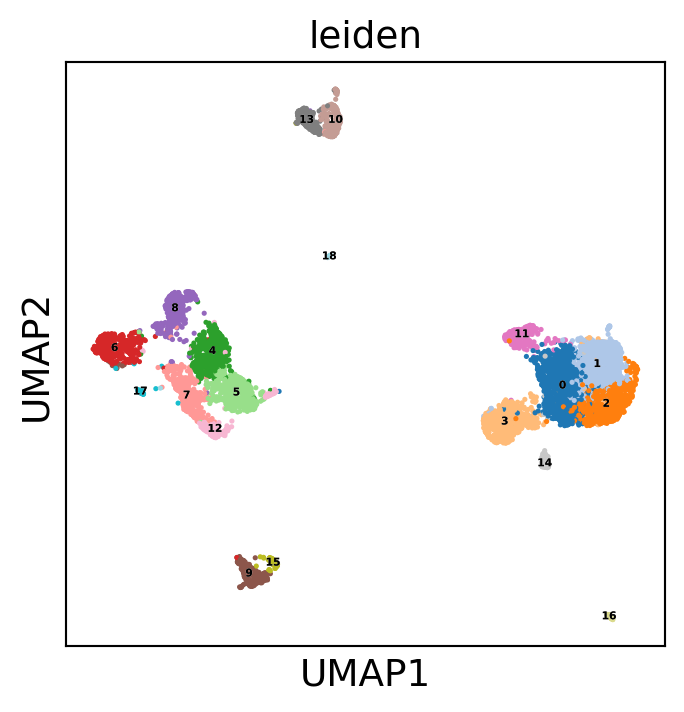

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



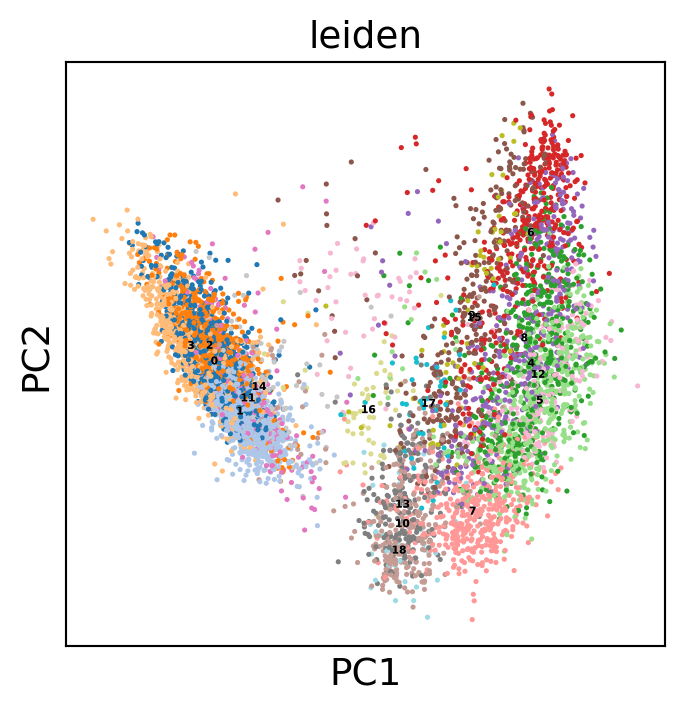

In [69]:
# Append cell type info to the dataset
sc.pl.umap(dataset, color='leiden', legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='tab20')
sc.pl.pca(dataset, color='leiden', legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='tab20')

Load the pre-analyzed 10k pbmc dataset.

In [71]:
dataset_rnaseq = sc.read_h5ad(path_pre_analyzed_10k_pbmcs)

Sum up the counts in peaks located over gene bodies.

In [73]:
gene_activity_matrix = gsea_obj.gene_activity_matrix(dataset)

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [74]:
detectable = muffin.tools.trim_low_counts(gene_activity_matrix)
gene_activity_matrix = gene_activity_matrix[:, detectable]

In [75]:
gene_activity_matrix.var_names_make_unique()

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 248 tasks      | elapsed:  1.3min
[Parallel(n_jobs=16)]: Done 2000 out of 2000 | elapsed:  2.9min finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:  1.4min
[Parallel(n_jobs=16)]: Done 41094 tasks      | elapsed:  3.2min
[Parallel(n_jobs=16)]: Done 44007 out of 44007 | elapsed:  3.2min finished
/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/tools.py:537: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



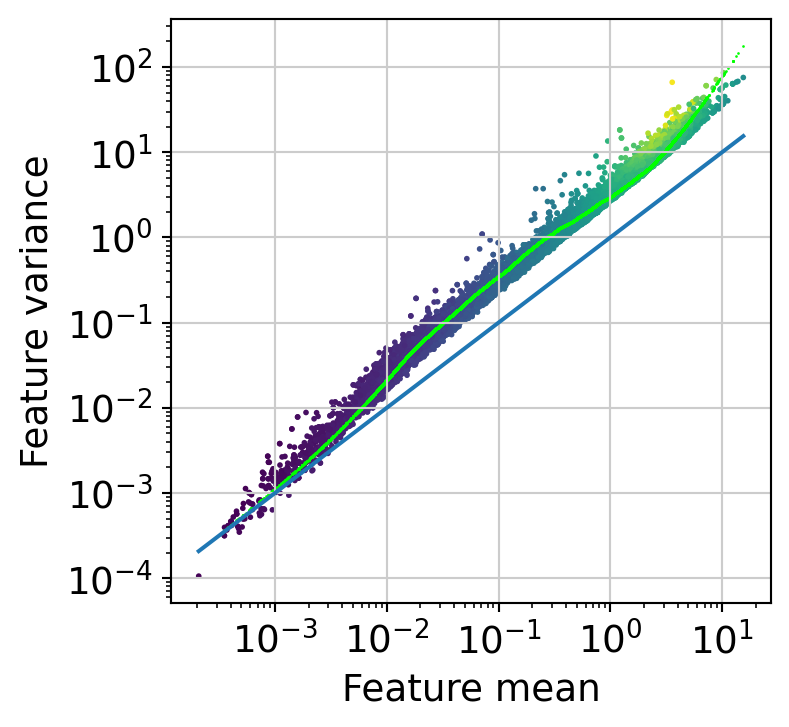

AnnData object with n_obs × n_vars = 7304 × 44007
    obs: 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'FRiP', 'TSS_frac', 'MT_frac', 'blacklist_frac', 'size_factors', 'leiden'
    var: 'means', 'variances', 'reg_alpha'
    uns: 'pca', 'leiden_colors'
    obsm: 'design', 'X_pca', 'X_umap'
    layers: 'residuals'

In [76]:
muffin.tools.compute_residuals(gene_activity_matrix, maxThreads=16)

Perform CCA to integrate datasets. As a rule of thumb, we'll use the same number of significant PCs in the reference dataset as the number of components.

In [77]:
muffin.tools.cca(dataset_rnaseq, gene_activity_matrix, dataset_rnaseq.obsm["X_pca"].shape[1])

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/tools.py:848: UserWarning:

Warning, not all variables are shared between both datasets, 15653 in common left



/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



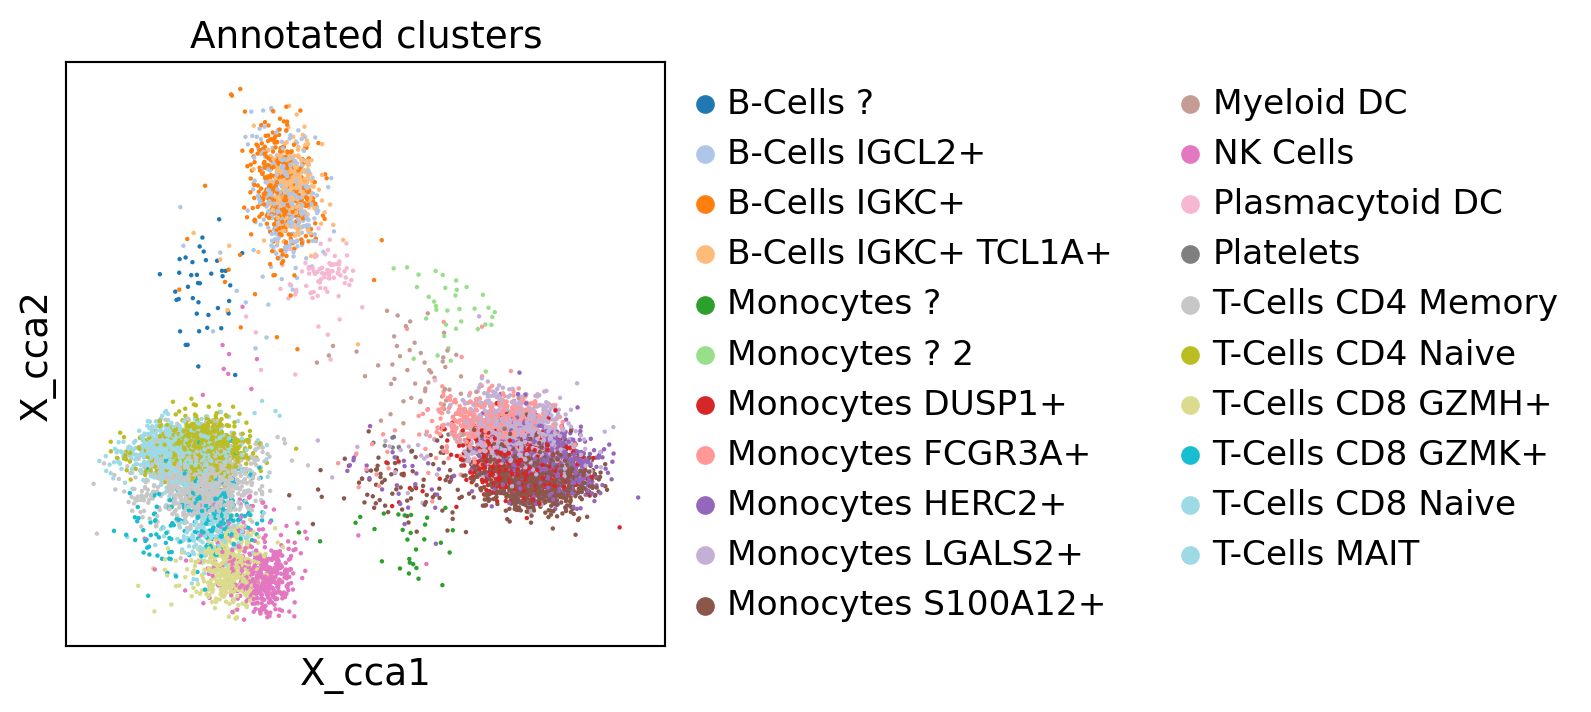

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



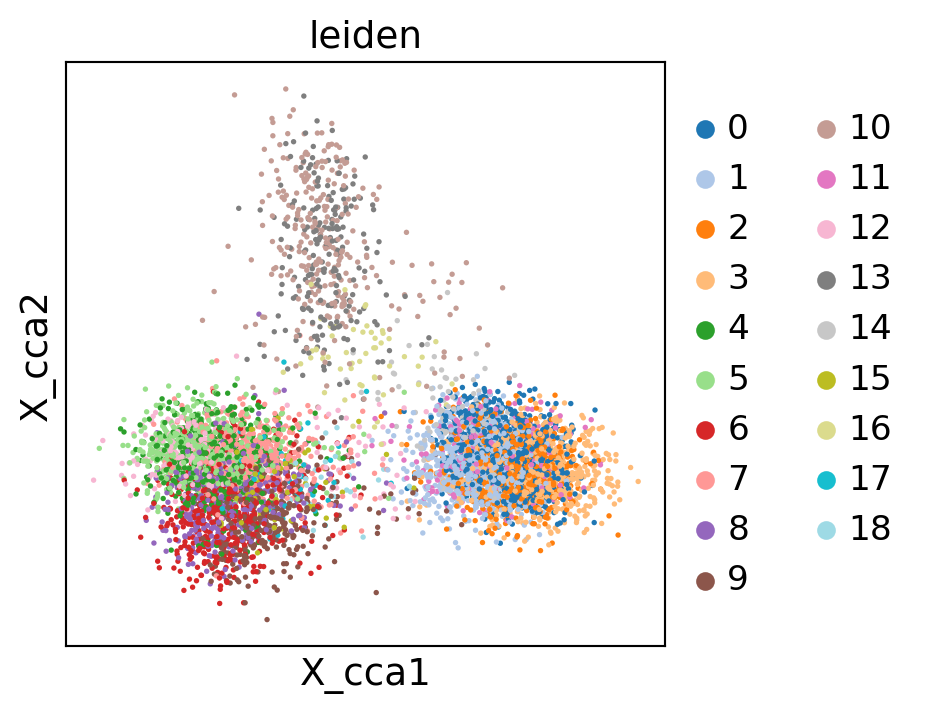

In [78]:
sc.pl.embedding(dataset_rnaseq, "X_cca", color="Annotated clusters")
sc.pl.embedding(gene_activity_matrix, "X_cca", color="leiden")

Align the CCA latent spaces using harmony.

/tmp/ipykernel_14360/69058780.py:1: FutureWarning:

Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html

2024-04-09 13:03:53,021 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-09 13:03:57,560 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-09 13:03:57,841 - harmonypy - INFO - Iteration 1 of 10
2024-04-09 13:04:05,480 - harmonypy - INFO - Iteration 2 of 10
2024-04-09 13:04:12,926 - harmonypy - INFO - Iteration 3 of 10
2024-04-09 13:04:17,488 - harmonypy - INFO - Iteration 4 of 10
2024-04-09 13:04:21,686 - harmonypy - INFO - Iteration 5 of 10
2024-04-09 13:04:25,365 - harmonypy - INFO - Iteration 6 of 10
2024-04-09 13:04:28,436 - harmonypy - INFO - Iteration 7 of 10
2024-04-09 13:04:31,426 - harmonypy - INFO - Iteration 8 of 10
2024-04-09 13:04:33,988 - harmonypy - INFO - Conve

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



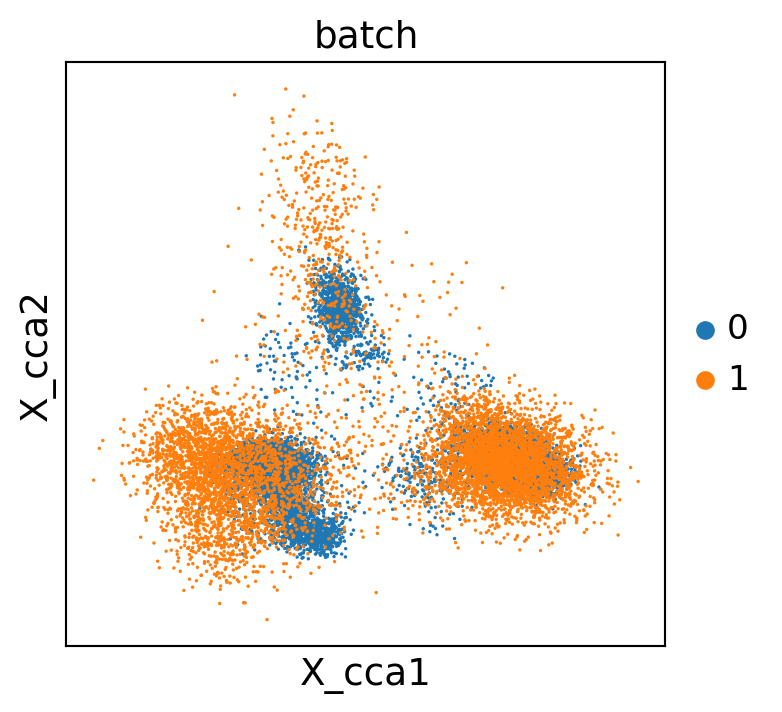

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



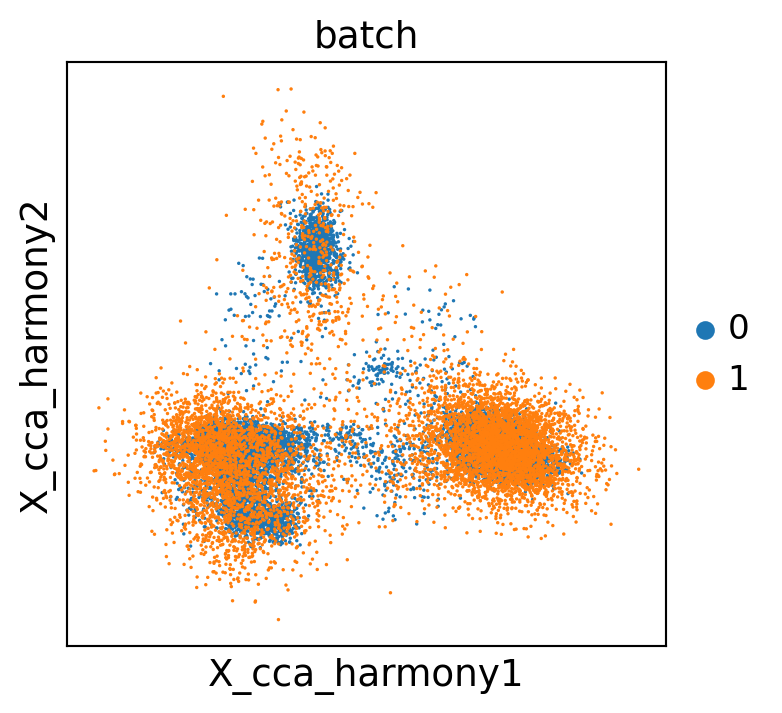

In [79]:
concat = dataset_rnaseq.concatenate(gene_activity_matrix)
sc.external.pp.harmony_integrate(concat, "batch", basis="X_cca", adjusted_basis="X_cca_harmony")
sc.pl.embedding(concat, "X_cca", color="batch")
sc.pl.embedding(concat, "X_cca_harmony", color="batch")

Transfer the corrected CCA spaces to the original objects

In [80]:
gene_activity_matrix.obsm["X_cca_harmony"] = concat[concat.obs["batch"]=="1"].obsm["X_cca_harmony"]
dataset_rnaseq.obsm["X_cca_harmony"] = concat[concat.obs["batch"]=="0"].obsm["X_cca_harmony"]

Transfer labels using a Random Forest Classifier trained on the CCA space and labels of the ref dataset (rnaseq). 
The transfered labels appear quite coherent, especially considering we are integrating datasets using vastly different protocols. As expected, platelets cannot be recovered as they do not have a nucleus and thus cannot appear on ATAC-seq.

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



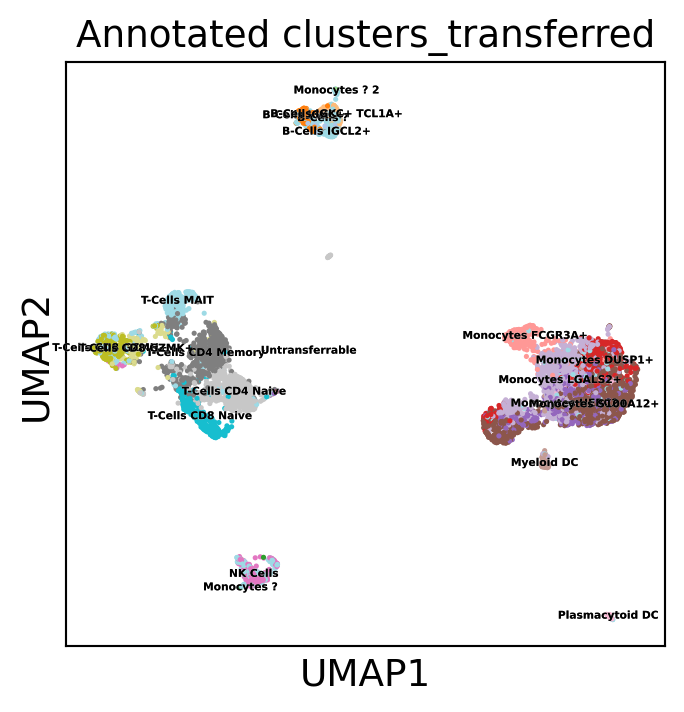

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



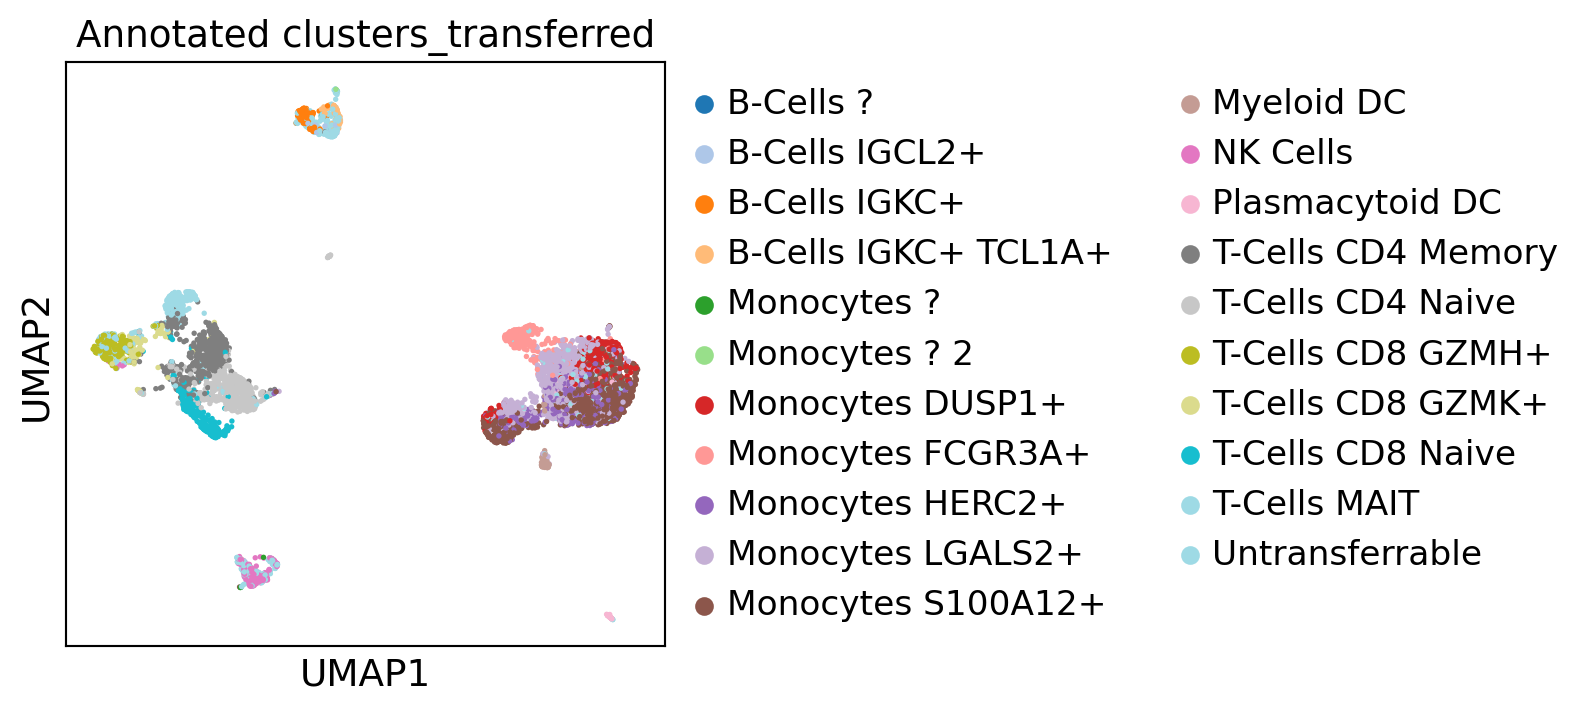

Annotated clusters_transferred
Monocytes S100A12+      1264
Monocytes LGALS2+        977
T-Cells CD4 Memory       706
Untransferrable          686
T-Cells CD4 Naive        630
Monocytes HERC2+         532
Monocytes DUSP1+         426
T-Cells CD8 Naive        424
Monocytes FCGR3A+        301
T-Cells CD8 GZMH+        269
T-Cells MAIT             262
NK Cells                 221
T-Cells CD8 GZMK+        159
B-Cells IGKC+ TCL1A+     113
Myeloid DC               113
B-Cells IGKC+            113
Plasmacytoid DC           67
B-Cells IGCL2+            23
Monocytes ? 2              9
Monocytes ?                5
B-Cells ?                  4
Name: count, dtype: int64

In [81]:
muffin.tools.transfer_categorical_labels(dataset_rnaseq, gene_activity_matrix, "Annotated clusters", "X_cca_harmony")
sc.pl.umap(gene_activity_matrix, color="Annotated clusters_transferred", legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0, palette="tab20")
sc.pl.umap(gene_activity_matrix, color="Annotated clusters_transferred", palette="tab20")
gene_activity_matrix.obs["Annotated clusters_transferred"].value_counts()


Visualize in joint embedding space.

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



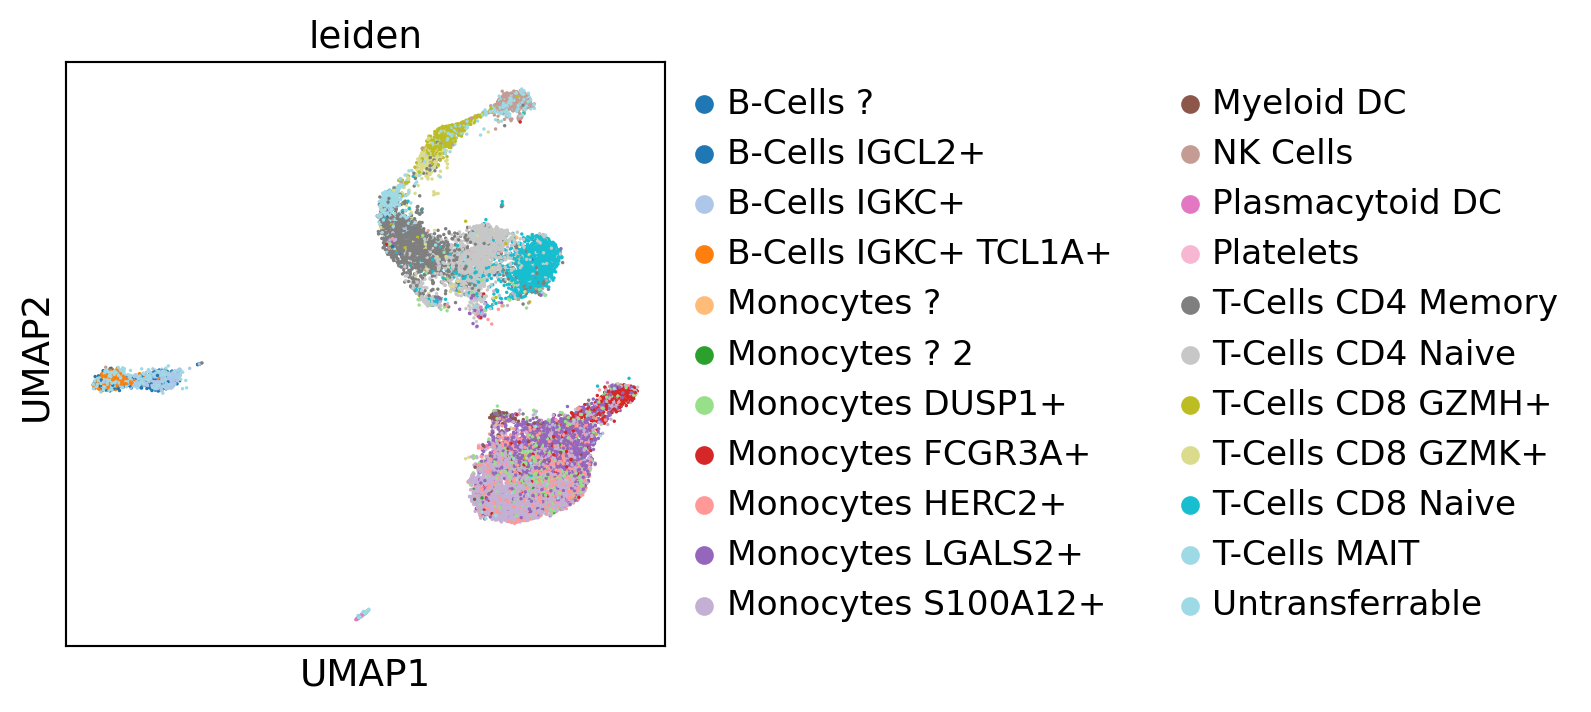

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



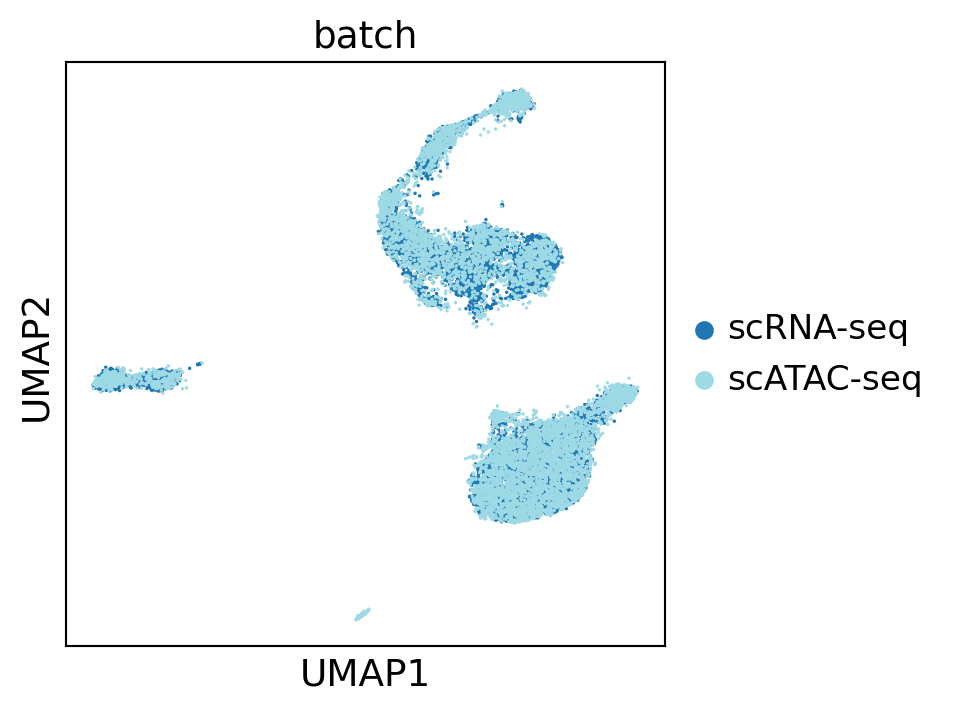

In [82]:
muffin.tools.compute_umap(concat, which="X_cca_harmony")
concat.obs["batch"] = concat.obs["batch"].cat.rename_categories(["scRNA-seq", "scATAC-seq"])
concat.obs["leiden"] = concat.obs["leiden"].astype(str)
concat.obs.loc[concat.obs["batch"] == "scATAC-seq", "leiden"] = gene_activity_matrix.obs["Annotated clusters_transferred"].astype(str).values
concat.obs.loc[concat.obs["batch"] == "scRNA-seq", "leiden"] = dataset_rnaseq.obs["Annotated clusters"].astype(str).values
sc.pl.umap(concat[concat.obs["leiden"] != "???"], color="leiden", palette="tab20", save="_labels_joint")
sc.pl.umap(concat[concat.obs["leiden"] != "???"], color="batch", palette="tab20", save="_batch_joint")

Transfer the label back to the original anndata object with atac-seq peak counts.

In [83]:
dataset.obs["RNA-seq labels"] = gene_activity_matrix.obs["Annotated clusters_transferred"]

In [84]:
from sklearn.preprocessing import StandardScaler
dataset.layers["scaled"] = StandardScaler().fit_transform(dataset.layers["residuals"])
sc.tl.rank_genes_groups(dataset, 'RNA-seq labels', use_raw=False, layer="scaled",
                        method='logreg', class_weight="balanced")

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Lets have a look at which GO terms are enriched in marker peaks for the largest B-Cell cluster. We'll take the top 5% markers.

In [85]:
background = dataset.var[["Chromosome", "Start", "End"]]
query = dataset.var.loc[dataset.uns["rank_genes_groups"]["names"]["B-Cells IGKC+"][:int(dataset.shape[1]*0.05)]][["Chromosome", "Start", "End"]]
results = gsea_obj.find_enriched(query, background, cores=16)

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavio

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning:

Data was converted to boolean for metric yule

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/great.py:605: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/great.py:608: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(<Figure size 384x384 with 1 Axes>, <Axes: xlabel='-log10(Corrected P-value)'>)

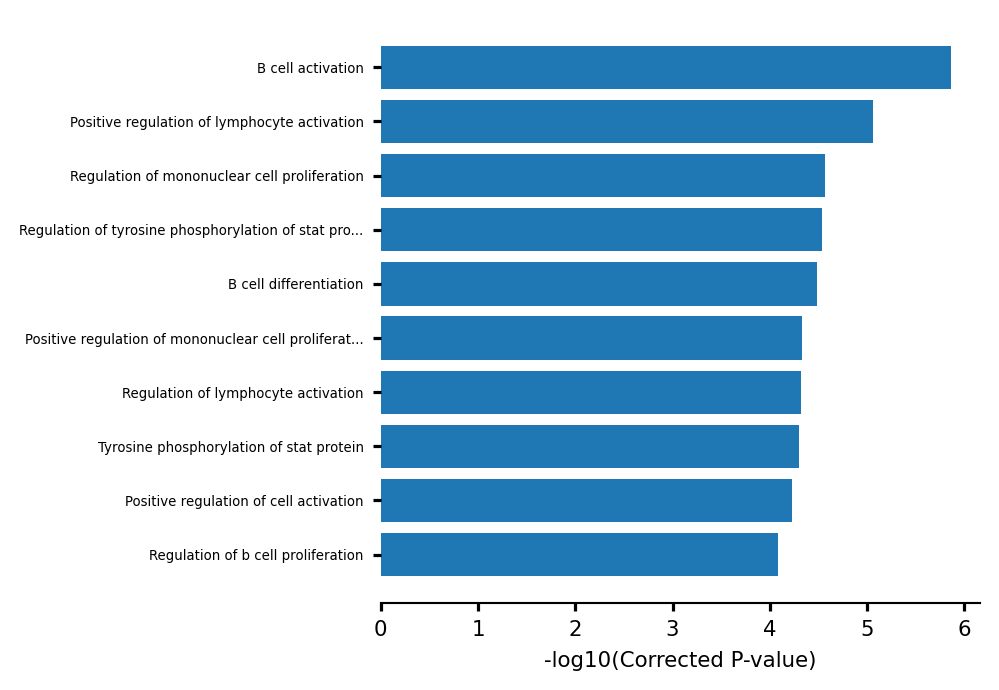

In [86]:
cluster_results = gsea_obj.cluster_treemap(results, output="scATAC_pbmc_bcells_cluster_treemap.pdf")
gsea_obj.barplot_enrich(results, savePath="scATAC_pbmc_bcells_barplot.pdf")